In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

from SDT import SDT

In [2]:
def onehot_coding(target, device, output_dim):
    """Convert the class labels into one-hot encoded vectors."""
    target_onehot = torch.FloatTensor(target.size()[0], output_dim).to(device)
    target_onehot.data.zero_()
    target_onehot.scatter_(1, target.view(-1, 1), 1.0)
    return target_onehot


# Parameters
input_dim = 28 * 28    # the number of input dimensions
output_dim = 10        # the number of outputs (i.e., # classes on MNIST)
depth = 5              # tree depth
lamda = 1e-3           # coefficient of the regularization term 
weight_decaly = 5e-4   # weight decay
batch_size = 128       # batch size
epochs = 50            # the number of training epochs
log_interval = 100     # the number of batches to wait before printing logs
use_cuda = False       # whether to use GPU

# Model and Optimizer
tree = SDT(input_dim, output_dim, depth, lamda, use_cuda)

# Load data
data_dir = "datasets/stl10_binary"

transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir,
                    train=True,
                    download=True,
                    transform=transformer),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir,
                    train=False,
                    transform=transformer),
    batch_size=batch_size,
    shuffle=True,
)

device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
tree.load_state_dict(torch.load('saved_models/tree_state_dict.pth'))
tree.eval()

SDT(
  (inner_nodes): Sequential(
    (0): Linear(in_features=785, out_features=31, bias=False)
    (1): Sigmoid()
  )
  (leaf_nodes): Linear(in_features=32, out_features=10, bias=False)
)

[[ 1.07293914e-03  1.06808008e-03  1.07305893e-03 ...  1.06942339e-03
   1.06970966e-03  1.06660521e-03]
 [-1.10686778e-05 -1.01575515e-05 -1.11460677e-05 ... -1.10684168e-05
  -1.09727534e-05 -1.05166373e-05]
 [-4.26815204e-05 -4.27398045e-05 -4.25269463e-05 ... -4.24410100e-05
  -4.23025631e-05 -4.24773389e-05]
 ...
 [-2.08594676e-04 -2.08651370e-04 -2.09361970e-04 ... -2.08738871e-04
  -2.07454039e-04 -2.06760480e-04]
 [-1.42489513e-03 -1.42328592e-03 -1.42942590e-03 ... -1.42538408e-03
  -1.41621171e-03 -1.41135999e-03]
 [ 1.70117021e-02  1.70727745e-02  1.70333013e-02 ...  1.70152858e-02
   1.70144103e-02  1.70367509e-02]]


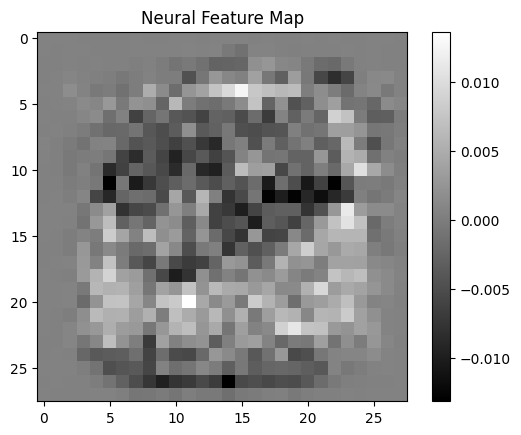

In [4]:
# Load a batch of data from the test_loader or train_loader
data_iter = iter(test_loader)
X, _ = next(data_iter)  # Only fetch the inputs (ignore the targets)

# Move the data to the correct device
# Flatten the images and move to the device
X = X.view(-1, input_dim).to(device)

# Compute the Neural Feature Map for this batch of data
nfm = tree.compute_nfm(X)

# Now `nfm` contains the feature importances, which you can print or analyze further
print(nfm)

# For example, you could visualize the average NFM across all features

# Assuming nfm is a 2D array where the first dimension is the batch size
avg_nfm = nfm.mean(axis=0)  # Average over all samples in the batch

# Reshape to the original image size if necessary (e.g., for MNIST 28x28)
avg_nfm = avg_nfm.reshape(28, 28)

# Plot the average NFM
plt.imshow(avg_nfm, cmap='grey', interpolation='nearest')
plt.colorbar()
plt.title('Neural Feature Map')
plt.show()

In [39]:
import os
from dataset import get_mnist
from SDT import SDT
import torch

# Parameters
input_dim = 28 * 28    # the number of input dimensions
output_dim = 10        # the number of outputs (i.e., # classes on MNIST)
depth = 5              # tree depth
lamda = 1e-3           # coefficient of the regularization term
weight_decaly = 5e-4   # weight decay
batch_size = 128       # batch size
epochs = 50            # the number of training epochs
log_interval = 100     # the number of batches to wait before printing logs
use_cuda = False       # whether to use GPU

mnist_tree = SDT(input_dim, output_dim, depth, lamda, use_cuda)

mnist_tree.load_state_dict(torch.load('saved_models/tree_state_dict.pth'))
mnist_tree.eval()

train_loader, val_loader, test_loader = get_mnist(os.path.join(os.getcwd(), 'datasets'), 128, 10)

for images, labels in test_loader:
    zero_class_indices = (labels[:, 0] == 1).nonzero(as_tuple=True)[0]

    # exit if we find any zero class elements
    if zero_class_indices.numel() > 0:
        first_zero_index = zero_class_indices[0]
        zero_image = images[first_zero_index]
        zero_label = labels[first_zero_index]
        break 

Loading MNIST dataset
Loaded MNIST


In [20]:
decision_path = mnist_tree._forward(zero_image, is_decision_pth=True)

In [21]:
decision_path = decision_path[0]

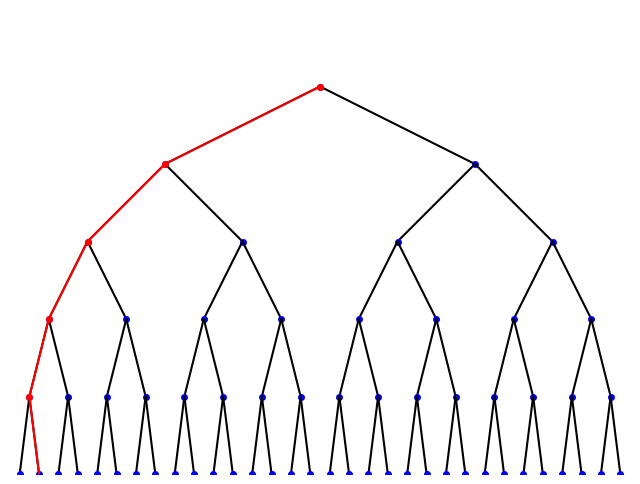

In [30]:
from path_viz import extract_path_from_tensors, plot_complete_tree_with_decision_path

path = extract_path_from_tensors(decision_path)
plot_complete_tree_with_decision_path(path)

In [29]:
path

[[0], [0], [0], [0], [1]]

In [23]:
linear_layer_weights = mnist_tree.inner_nodes[0].weight.detach().cpu().numpy()

In [93]:
len_weights =  len(mnist_tree.leaf_nodes.weight[1].detach().cpu().numpy())

In [98]:
lst_weights = list(range(len_weights-1))

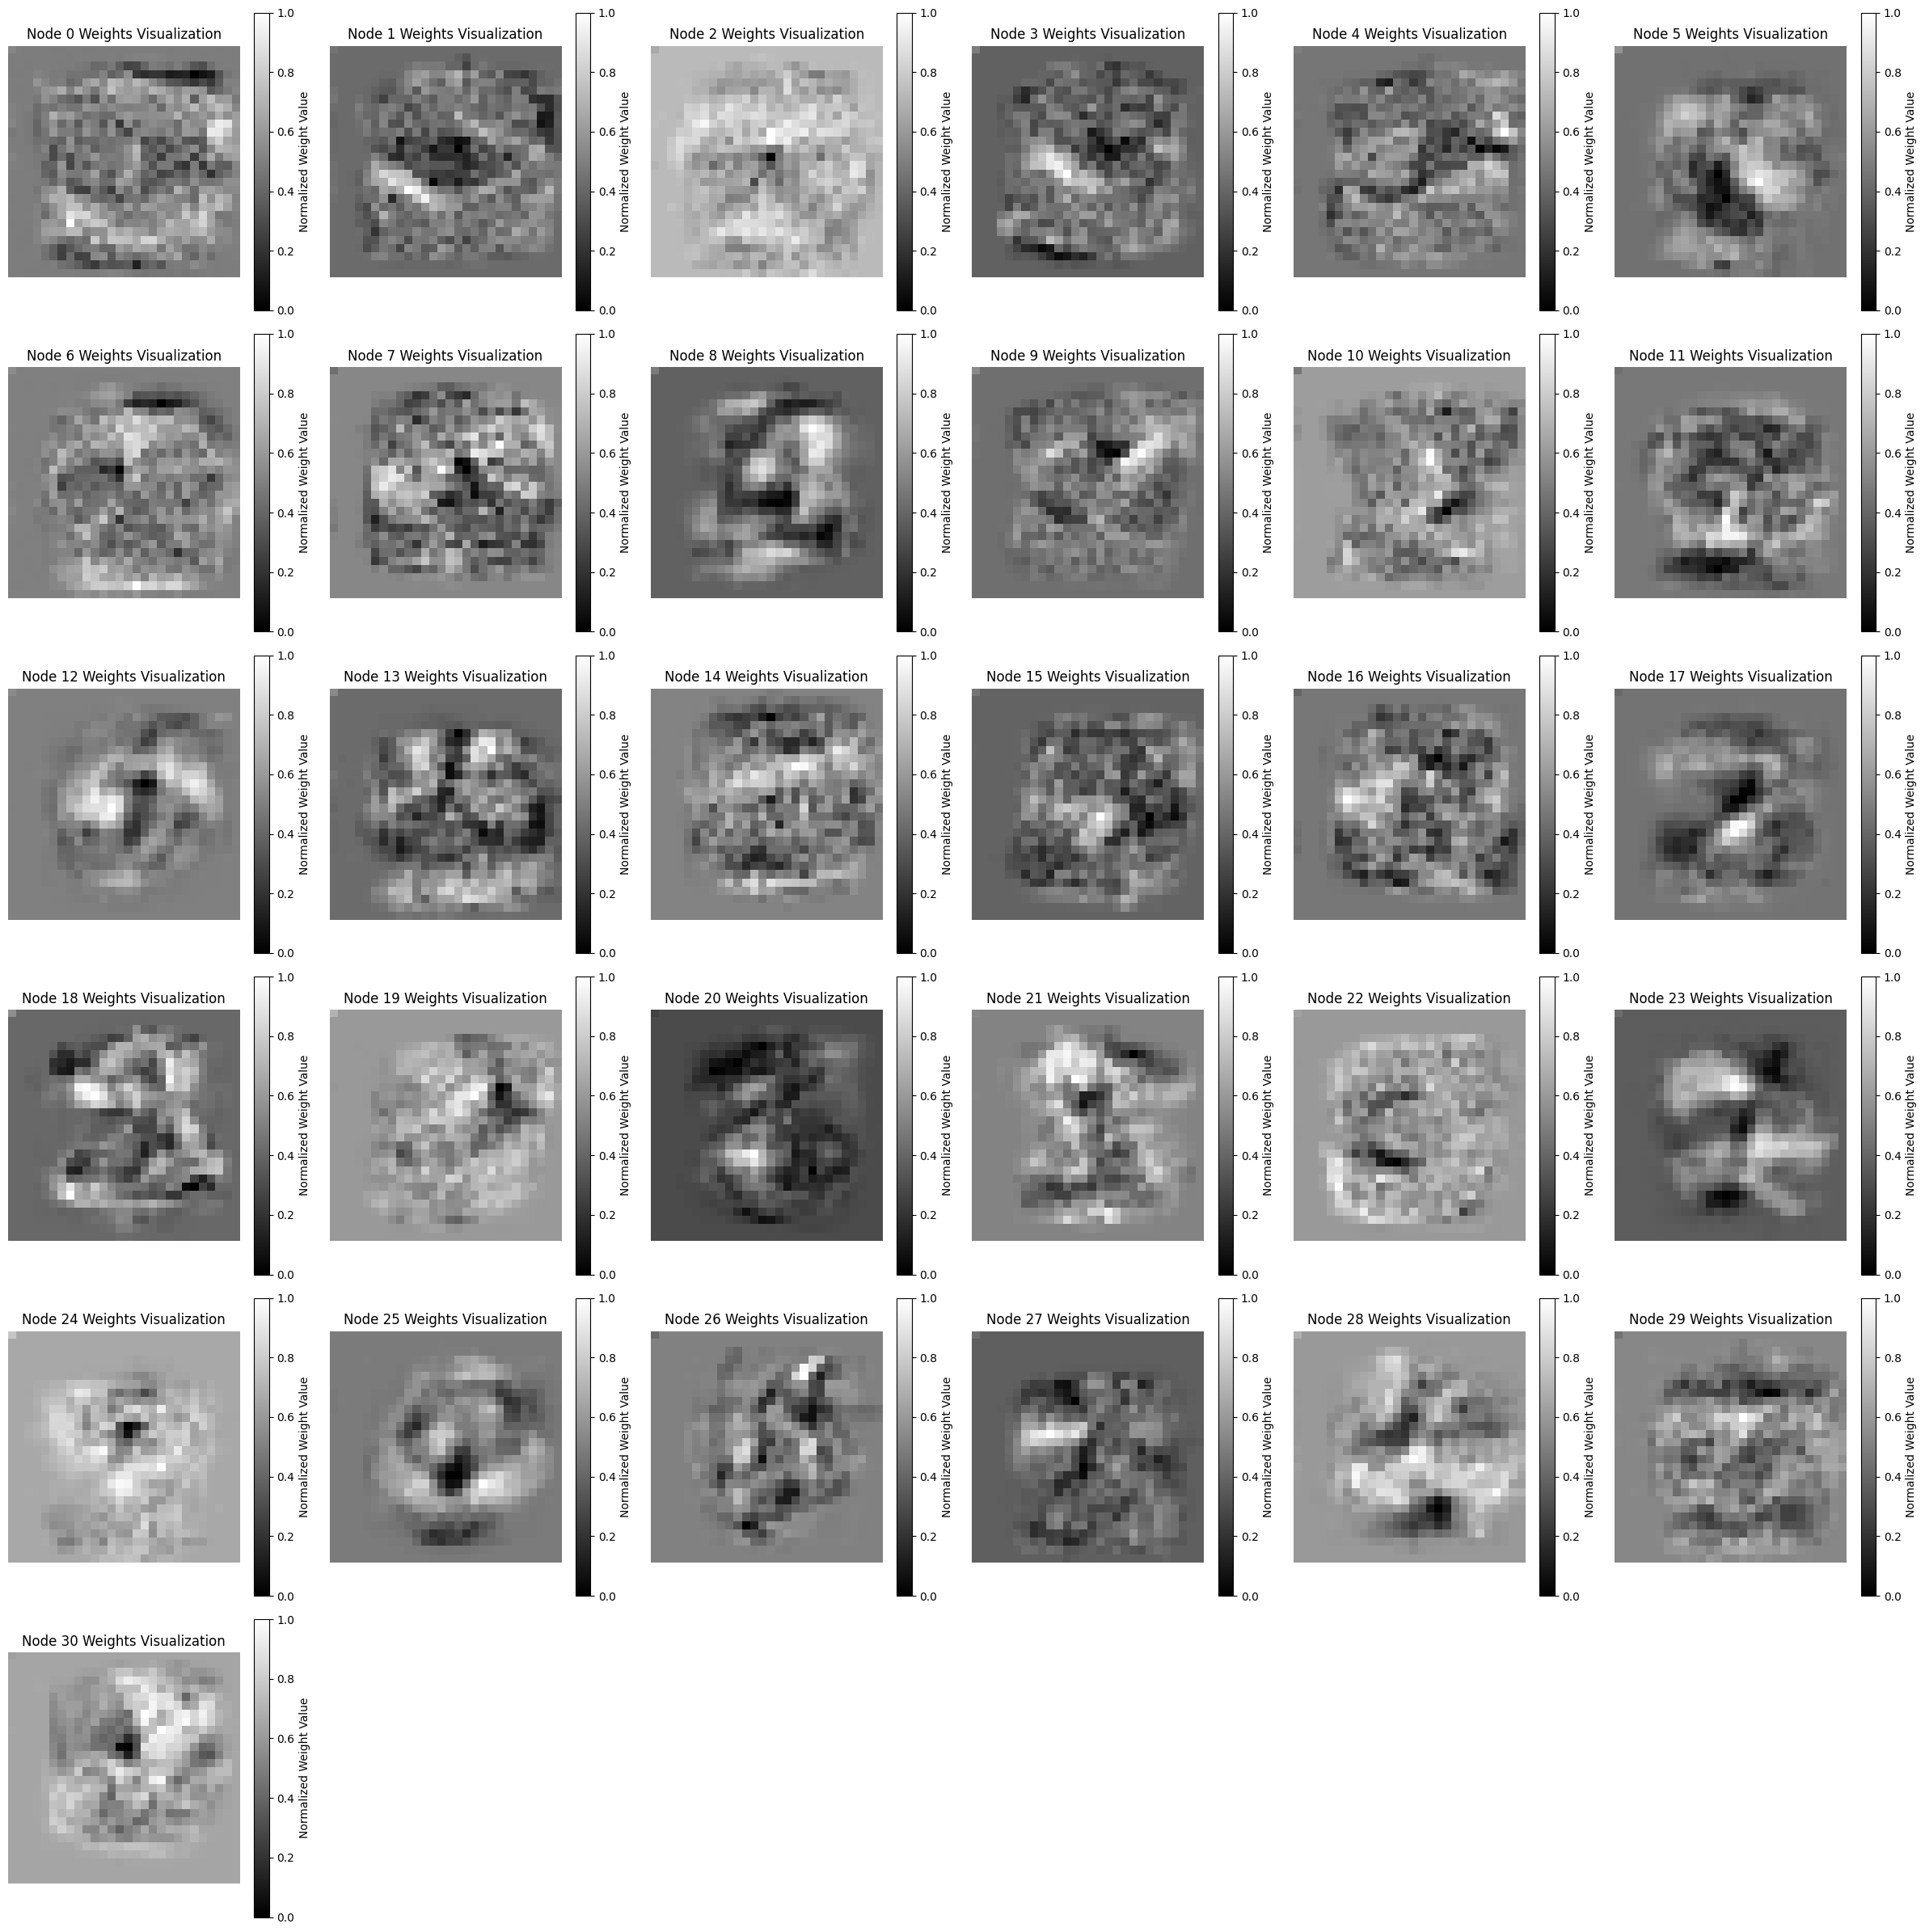

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mnist_tree.inner_nodes[0].weight[i].data.cpu().numpy() correctly fetches the weight
# for a node 'i', and 'lst_weights' contains indices of nodes to visualize
# 
# lst_weights = [0, 1, 3, 7, 15]
grid_size = int(np.ceil(np.sqrt(len_weights)))

# Set up a single figure for all subplots
plt.figure(figsize=(grid_size * 4, grid_size * 4))

for idx, i in enumerate(lst_weights, 1):  # Start enumeration at 1 for subplot indexing

    weights = mnist_tree.inner_nodes[0].weight[i].data.cpu().numpy()
    weights = weights[:-1]  # Assuming the last weight is a bias term and should be excluded

    # Normalize weights to the range [0, 1] for grayscale visualization
    normalized_weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

    # Reshape weights for visualization
    image_shape = normalized_weights.reshape((28, 28))
        
    
    # Plot on a grid
    plt.subplot(grid_size, grid_size, idx)  # Plotting in subplot
    plt.imshow(image_shape, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Normalized Weight Value')
    plt.title(f'Node {i} Weights Visualization')
    plt.axis('off')  # Remove the axis

plt.tight_layout()
plt.show()


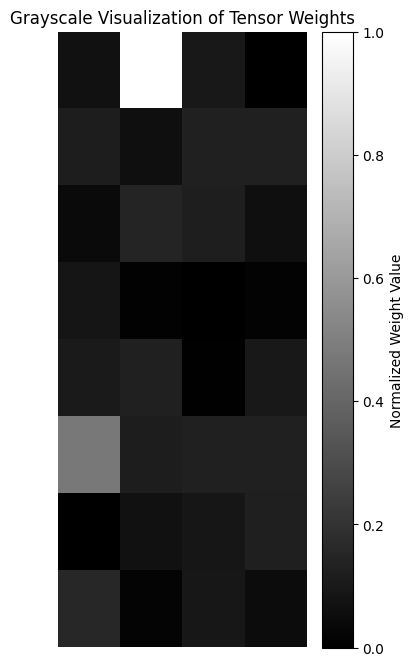

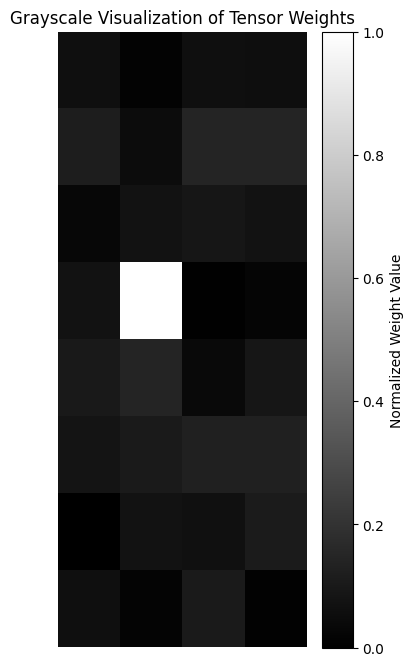

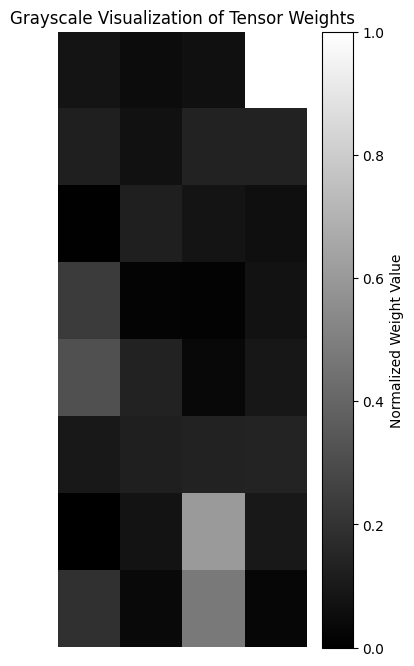

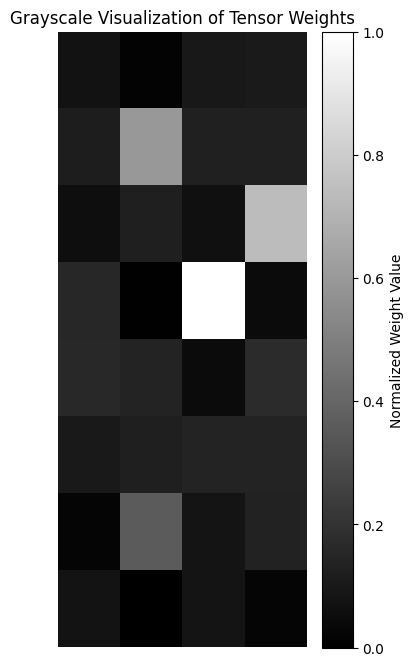

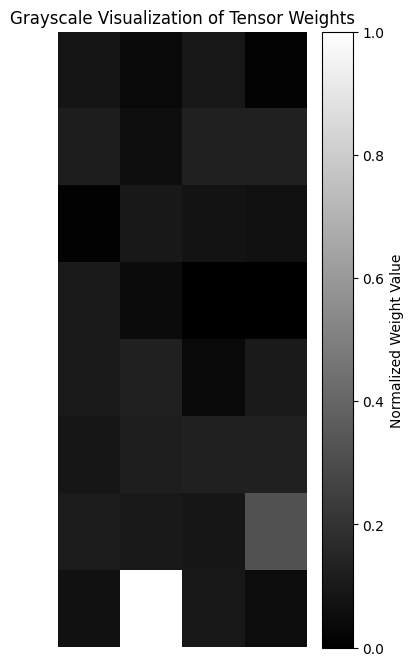

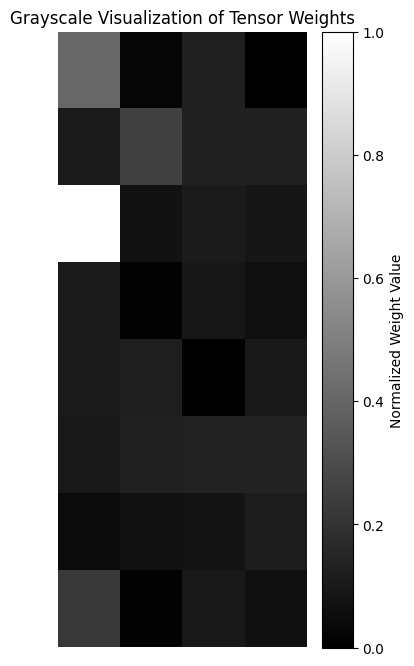

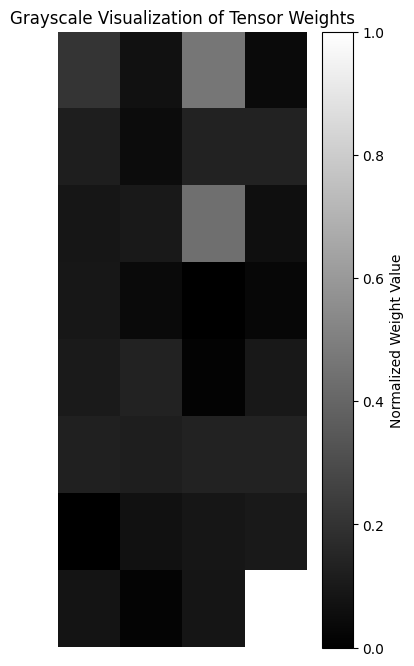

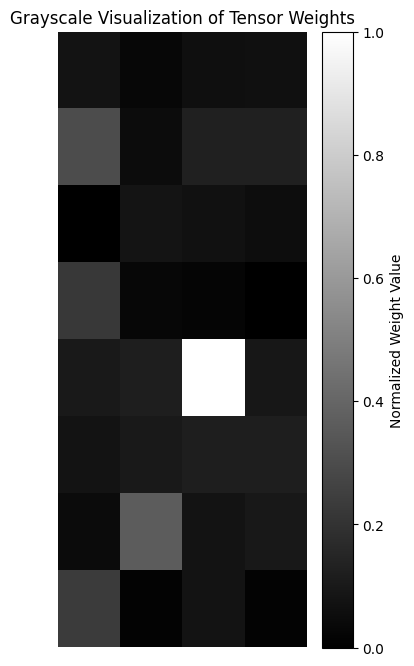

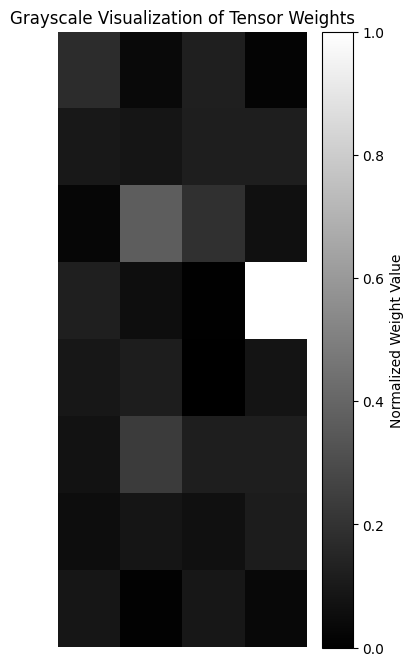

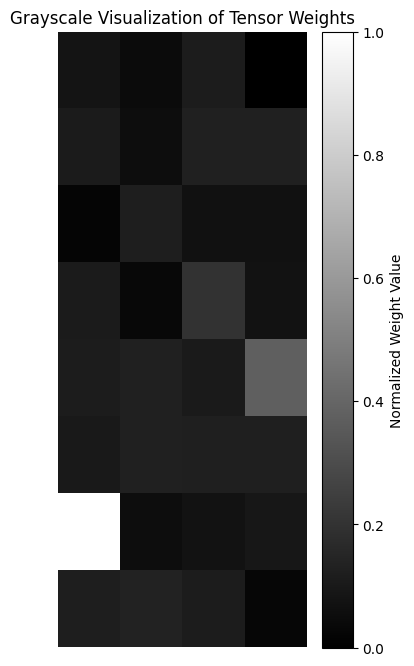

In [111]:
for i in range(len(mnist_tree.leaf_nodes.weight)):   
    weights_tensor = mnist_tree.leaf_nodes.weight[i]
    weights = weights_tensor.detach().numpy()
    
    weights_min = weights.min()
    weights_max = weights.max()
    normalized_weights = (weights - weights_min) / (weights_max - weights_min)
    
    # Reshape tensor to 2D shape for visualization
    weights_2d = normalized_weights.reshape((8, 4))
    
    # Visualization
    plt.figure(figsize=(4, 8))
    plt.imshow(weights_2d, cmap='gray', aspect='auto')
    plt.colorbar(label='Normalized Weight Value')
    plt.title('Grayscale Visualization of Tensor Weights')
    plt.axis('off')  # Optionally remove the axis for cleaner visualization
    plt.show()

In [24]:
# linear_layer_weights = abs(linear_layer_weights)

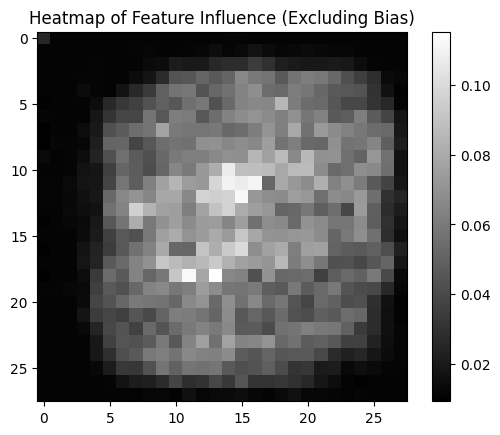

In [25]:
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
#  # Taking the absolute values for visualization
# 
# # Exclude the extra element (if it's the last one) before averaging and reshaping
# avg_weights = np.mean(linear_layer_weights[:, :-1], axis=0)  # Exclude the last element for each decision node
# 
# # Now you can reshape safely to a 28x28 image
# weight_image = avg_weights.reshape(28, 28)
# 
# # Visualize the heatmap
# plt.imshow(weight_image, cmap='grey', interpolation='nearest')
# plt.colorbar()
# plt.title("Heatmap of Feature Influence (Excluding Bias)")
# plt.show()

In [26]:
def compute_node_output_with_activation(weights, input_features, activation=torch.sigmoid):
    weighted_sum = torch.dot(weights, input_features)
    node_output = activation(weighted_sum)
    return node_output


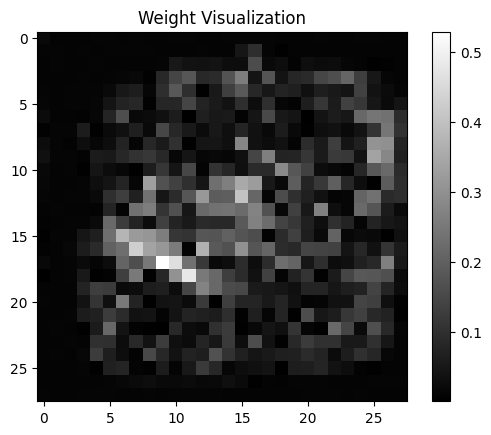

In [27]:
weights = linear_layer_weights[:, :-1]

selected_row = weights[1]  # Assuming you're interested in the first output neuron
image_shape_weights = selected_row.reshape(28, 28)  # Reshaping to the MNIST image shape

# Visualization
plt.imshow(image_shape_weights, cmap='grey', interpolation='nearest')
plt.colorbar()
plt.title("Weight Visualization")
plt.show()
# node_outputs = [compute_node_output_with_activation(torch.flatten(torch.tensor(weights)), torch.flatten(x)).numpy() for x in zero_image]
# 
# # Plotting
# plt.plot(zero_image, node_outputs)
# plt.xlabel('Input Feature Value')
# plt.ylabel('Node Output')
# plt.title('Node Output Across Input Feature Values')
# plt.show()

     Node  Activation Value Decision
0  Node 0               0.8     left
1  Node 1               0.6    right
2  Node 4               0.9     leaf


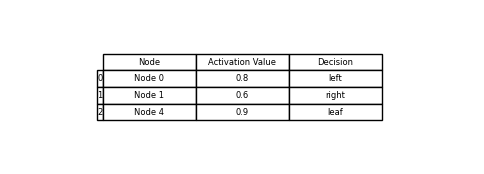

In [31]:
import pandas as pd

# Example data: list of tuples with (node_id, activation_value, decision)
# 'decision' could be 'left', 'right', or 'leaf' for terminal nodes
decision_path_data = [
    ('Node 0', 0.8, 'left'),
    ('Node 1', 0.6, 'right'),
    ('Node 4', 0.9, 'leaf'),
]

# Convert the data to a pandas DataFrame
df = pd.DataFrame(decision_path_data, columns=['Node', 'Activation Value', 'Decision'])

# Display the DataFrame as a table
print(df)

# For a more graphical table visualization, you can use matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
tbl = table(ax, df, loc='center', cellLoc='center', colWidths=[0.2]*len(df.columns))
plt.show()
